In [ ]:
# Material Balance & Decline Curve Analysis – Volve Field, Norway

This project uses production data from the Volve field (Norwegian Continental Shelf) to estimate reserves and evaluate production decline trends.

Using historical production data for multiple wellbores, the goal is to:
- Apply Decline Curve Analysis (DCA) models (exponential, harmonic, hyperbolic)
- Estimate Original Oil in Place (OOIP) using simplified material balance
- Estimate Forecast Future Production using Best-Fit Model
- Generate clean, visual plots to support reservoir performance interpretation

The analysis is implemented in **Python using:
- Openpyxl for reading Excel files
- pandas for data cleaning and manipulation
- matplotlib for plotting production trends and model fits
- NumPy for model fitting and curve calculations
- scipy.optimize (curve_fit) for nonlinear regression to fit exponential, harmonic, and hyperbolic decline models.
- sklearn.metrics for mean_squared_error and r2_score to evaluate model performance (RMSE and R²).

# Dataset Overview:
- Dataset Source: Equinor Volve Field Dataset  
- Accessed via: (https://www.equinor.com/energy/volve-data-sharing](https://www.equinor.com/energy/volve-data-sharing)

The dataset includes daily and monthly production volumes for 7 wellbores, including:
- Oil, gas, and water production (in Sm³)
- Well names, dates, and operational metadata
- Injection volumes (where available)

Please note: At the time of this analysis, access to the full PVT dataset was temporarily unavailable due to maintenance. 
Assumptions were used in place of unavailable parameters

#  Workflow:
 Load Excel →  Inspect structure →  Clean and reshape → Plot trends → Fit DCA → Estimate reserves

This project is structured to walk through the process of performing decline curve and material balance analysis on real Norwegian field data


In [ ]:
# 1: Import Required Libraries

We begin by importing the necessary Python libraries for loading, cleaning, and visualizing the production dataset.

These include:
- `pandas` for data handling
- `numpy` for numerical operations
- `matplotlib` for visualizing production rates and model fits
- `warnings` to suppress unwanted output

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


In [ ]:
# 2. Data Loading and Preprocessing

In this section, we will:
- Load the production dataset from the Excel file
- Select key columns relevant for decline curve and material balance analysis
- Check for duplicates and handle missing values
- Rename columns for consistency and clarity

We will begin with the **Daily Production Data** sheet, which includes oil, gas, water, and injection volumes at the wellbore level.


In [139]:
# 2.1. Load the Excel sheet using openpyxl engine
file_path = r"C:\Users\Joy\Downloads\VOLVE DATASET\Volve production data.xlsx"

# Load the Daily Production Data sheet
daily_df = pd.read_excel(file_path, sheet_name="Daily Production Data", engine="openpyxl")

# Display the first rows
daily_df.head()


,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,...,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.00000,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
2,2014-04-09,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
3,2014-04-10,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
4,2014-04-11,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,310.37614,...,%,33.09788,10.47992,33.07195,0.0,0.0,0.0,NaN,production,OP


In [ ]:
# 2.2. Select Key Columns Relevant for Decline Curve and Material Balance Analysis

From the full daily dataset, we select only the columns necessary for production performance analysis. These include:

- `DATEPRD`: Date of production
- `NPD_WELL_BORE_NAME`: Well name identifier
- `BORE_OIL_VOL`: Oil production volume (Sm³)
- `BORE_WAT_VOL`: Water production volume (Sm³)
- `BORE_GAS_VOL`: Gas production volume (Sm³)
- `BORE_WI_VOL`: Water injection volume (Sm³, if applicable)

We will keep only these columns to simplify analysis and ensure focus on production performance and decline trends.


In [141]:
# Select only the relevant columns for analysis
columns_to_keep = [
    "DATEPRD",               # Production date
    "NPD_WELL_BORE_NAME",    # Well name
    "BORE_OIL_VOL",          # Oil production volume (Sm³)
    "BORE_GAS_VOL",          # Gas production volume (Sm³)
    "BORE_WAT_VOL",          # Water production volume (Sm³)
    "BORE_WI_VOL"            # Water injection volume (Sm³)
]

# Create a new DataFrame with selected columns
df = daily_df[columns_to_keep].copy()

# Display the first few rows
df.head()


,DATEPRD,NPD_WELL_BORE_NAME,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL
0,2014-04-07,15/9-F-1 C,0.0,0.0,0.0,NaN
1,2014-04-08,15/9-F-1 C,0.0,0.0,0.0,NaN
2,2014-04-09,15/9-F-1 C,0.0,0.0,0.0,NaN
3,2014-04-10,15/9-F-1 C,0.0,0.0,0.0,NaN
4,2014-04-11,15/9-F-1 C,0.0,0.0,0.0,NaN


In [117]:
# 2.3. Check for duplicate rows
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

# Check for missing values
missing_summary = df.isnull().sum()
print("\nMissing values per column:\n", missing_summary)

# Drop rows where 'DATEPRD' or 'NPD_WELL_BORE_NAME' is missing
df = df.dropna(subset=["DATEPRD", "NPD_WELL_BORE_NAME"])

# Fill missing production values with 0 (assuming no production that day)
production_cols = ["BORE_OIL_VOL", "BORE_GAS_VOL", "BORE_WAT_VOL", "BORE_WI_VOL"]
df[production_cols] = df[production_cols].fillna(0)

# Recheck
print("\nAfter cleaning:")
print(df.isnull().sum())


Number of duplicate rows: 0

Missing values per column:
 DATEPRD                  0
NPD_WELL_BORE_NAME       0
BORE_OIL_VOL          6473
BORE_GAS_VOL          6473
BORE_WAT_VOL          6473
BORE_WI_VOL           9928
dtype: int64

After cleaning:
DATEPRD               0
NPD_WELL_BORE_NAME    0
BORE_OIL_VOL          0
BORE_GAS_VOL          0
BORE_WAT_VOL          0
BORE_WI_VOL           0
dtype: int64


In [143]:
# 2.4. Rename columns to clean, Pythonic names
df = df.rename(columns={
    "DATEPRD": "date",
    "NPD_WELL_BORE_NAME": "well_name",
    "BORE_OIL_VOL": "oil_vol_sm3",
    "BORE_GAS_VOL": "gas_vol_sm3",
    "BORE_WAT_VOL": "water_vol_sm3",
    "BORE_WI_VOL": "water_inj_vol_sm3"
})

# Preview result
df.head()


,date,well_name,oil_vol_sm3,gas_vol_sm3,water_vol_sm3,water_inj_vol_sm3
0,2014-04-07,15/9-F-1 C,0.0,0.0,0.0,NaN
1,2014-04-08,15/9-F-1 C,0.0,0.0,0.0,NaN
2,2014-04-09,15/9-F-1 C,0.0,0.0,0.0,NaN
3,2014-04-10,15/9-F-1 C,0.0,0.0,0.0,NaN
4,2014-04-11,15/9-F-1 C,0.0,0.0,0.0,NaN


In [ ]:
# 3. Filter a Single Well for Decline Curve Analysis

To begin decline curve modelling, we must isolate a single well with a  meaningful production history. 
This ensures a clean analysis of production performance over time.

# Criteria for Well Selection

We consider the following criteria:

- Long production history – the well has a high number of production days
- Continuous production – minimal gaps or interruptions in production
- Significant oil output – the well has a visible oil production trend
- Clear decline trend – production decreases over time, useful for decline modeling

We perform an initial count of daily records and total oil volume for each well to compare their suitability.

The selected well will then be:
- Visualised using oil production over time
- Used to compute the cumulative oil volume
- Fitted with decline models (in later sections)

This process helps validate our data and test the decline curve analysis workflow on a practical, real-world dataset from the Norwegian Volve field.


Production summary per well:


,well_name,num_days_produced,total_oil_sm3
0,15/9-F-4,3327,0.00
1,15/9-F-5,3306,41160.68
2,15/9-F-12,3056,4579609.55
3,15/9-F-14,3056,3942233.39
4,15/9-F-11,1165,1147849.10
5,15/9-F-15 D,978,148518.56
6,15/9-F-1 C,746,177709.33


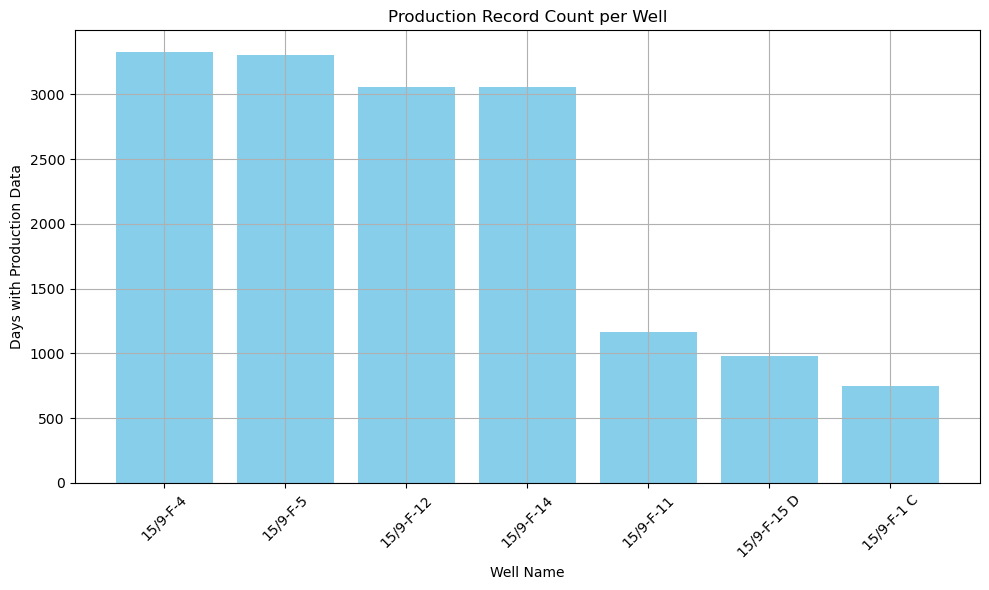

In [147]:
# Count number of production records per well
well_counts = df['well_name'].value_counts().reset_index()
well_counts.columns = ['well_name', 'num_days_produced']

# Sum total oil volume per well
oil_volume = df.groupby('well_name')['oil_vol_sm3'].sum().reset_index()
oil_volume.columns = ['well_name', 'total_oil_sm3']

# Merge both summaries
well_summary = pd.merge(well_counts, oil_volume, on='well_name')

# Sort by number of production days
well_summary = well_summary.sort_values(by='num_days_produced', ascending=False)

# Preview
print("Production summary per well:")
display(well_summary)

# plot
plt.figure(figsize=(10, 6))
plt.bar(well_summary['well_name'], well_summary['num_days_produced'], color='skyblue')
plt.xticks(rotation=45)
plt.title('Production Record Count per Well')
plt.xlabel('Well Name')
plt.ylabel('Days with Production Data')
plt.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
# 3.1. Filter a Single Well for Decline Curve Analysis

To begin decline curve modeling, we select a single well from the dataset. 
This helps isolate its production performance over time and test our analysis workflow.

We will:
- Filter the dataset by well name
- Sort the records by date (important for cumulative calculation and time plots)
- Plot oil production rate over time to observe decline behavior


Available wells:
 ['15/9-F-1 C' '15/9-F-11' '15/9-F-12' '15/9-F-14' '15/9-F-15 D' '15/9-F-4'
 '15/9-F-5']


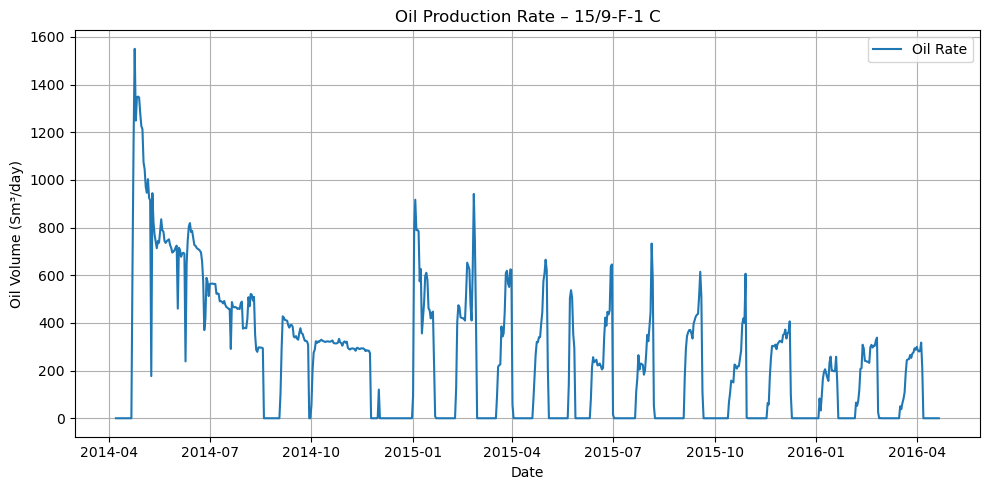

In [149]:
# List unique well names to choose from
unique_wells = df["well_name"].unique()
print("Available wells:\n", unique_wells)

# Define and filter selected well
selected_well_1 = "15/9-F-1 C"
well_df_1 = df[df["well_name"] == selected_well_1].sort_values("date").copy()

# Plot oil rate over time
plt.figure(figsize=(10, 5))
plt.plot(well_df_1["date"], well_df_1["oil_vol_sm3"], label="Oil Rate", color="tab:blue")
plt.title(f"Oil Production Rate – {selected_well_1}")
plt.xlabel("Date")
plt.ylabel("Oil Volume (Sm³/day)")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
The spikes and gaps clearly show intermittent production, which is not ideal for decline curve modeling due to:

- Frequent shut-ins or operational stops
- Erratic profile that makes decline fitting unstable

We try another well since they are 7 wells in total


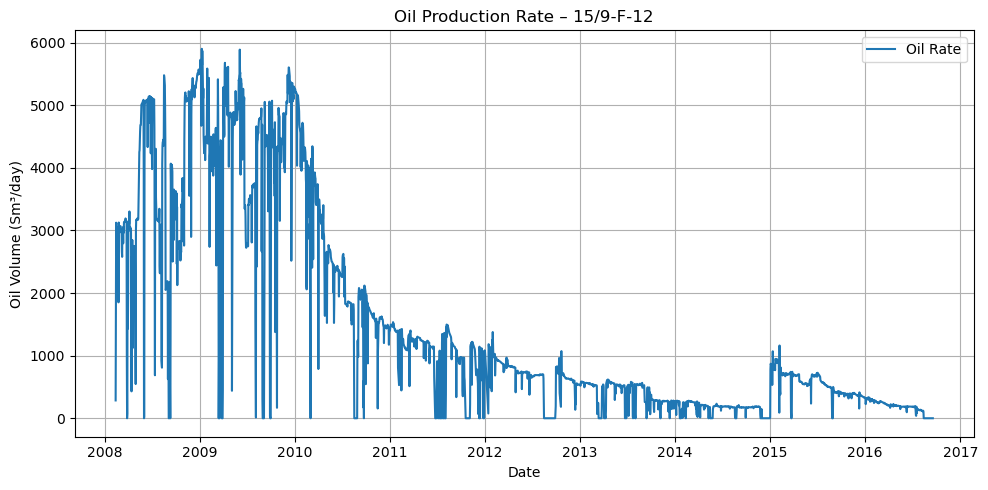

In [151]:
# For well 15/9-F-12 
selected_well_2 = "15/9-F-12"
well_df_2 = df[df["well_name"] == selected_well_2].sort_values("date").copy()

# Plot oil rate over time for second well
plt.figure(figsize=(10, 5))
plt.plot(well_df_2["date"], well_df_2["oil_vol_sm3"], label="Oil Rate", color="tab:blue")
plt.title(f"Oil Production Rate – {selected_well_2}")
plt.xlabel("Date")
plt.ylabel("Oil Volume (Sm³/day)")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
# 3.2. Justification for Selecting Well 15/9-F-12

Well 15/9-F-12 was selected for decline curve modelling due to the following reasons:

- Long production record: Over 3000 days of daily production data.
- Significant oil production: Cumulative oil volume exceeding 4.5 million Sm³.
- Continuous production: Data shows few interruptions over the operational period.
- Clear decline pattern: Ideal for fitting decline models such as Exponential, Harmonic, or Hyperbolic.

This well meets all the criteria for performing reliable reservoir analysis.


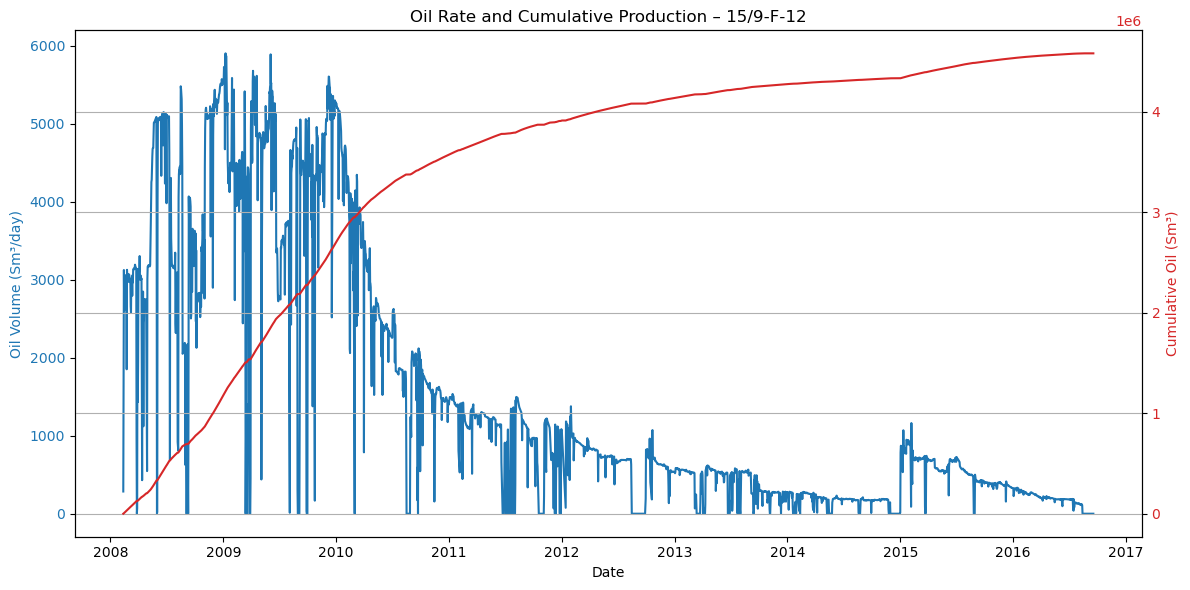

In [153]:
# 3.3 Calculate cumulative oil production for selected well
well_df_2['cum_oil_sm3'] = well_df_2['oil_vol_sm3'].cumsum()

# Plot daily oil rate and cumulative oil on twin axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary y-axis: oil rate
ax1.plot(well_df_2['date'], well_df_2['oil_vol_sm3'], label='Oil Rate', color='tab:blue')
ax1.set_xlabel("Date")
ax1.set_ylabel("Oil Volume (Sm³/day)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Secondary y-axis: cumulative oil
ax2 = ax1.twinx()
ax2.plot(well_df_2['date'], well_df_2['cum_oil_sm3'], label='Cumulative Oil', color='tab:red')
ax2.set_ylabel("Cumulative Oil (Sm³)", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title(f"Oil Rate and Cumulative Production – {selected_well_2}")
fig.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
# 4. Decline Curve Analysis (DCA)

We now fit analytical models to the production data using standard decline equations.  
This is the core of decline curve modelling, which helps estimate future production trends and reservoir behaviour.

The three most common analytical DCA models are:

# • Exponential Decline: Constant percentage decline  
    q(t) = q_i e^{-Dt} 

# • Harmonic Decline: Decline slows over time  
    q(t) = \frac{q_i}{1 + Dt} 

# • Hyperbolic Decline: Flexible, with decline exponent \( b \)  
    q(t) = \frac{q_i}{(1 + bDt)^{1/b}} 

Where:
- ( q(t) ): Production rate at time  
- ( q_i ): Initial production rate  
- ( D ): Decline rate  
- ( b ): Hyperbolic exponent  
- ( t ): Time (days since first production)

These models will now be fitted to the selected well’s historical oil production data.

We will:
- Prepare time and rate data from the selected well (15/9-F-12)
- Define each DCA model's function
- Use curve_fit to estimate parameters qiqi​ and DD.
- Plot the actual vs. fitted curve for comparison 
- Evaluate Model Performance
                                 

In [171]:
# 4.1 Prepare Time and Rate Data for 15/9-F-12
# Convert 'date' to days since first production and extract oil rate q(t)

# Create time variable (t) as days since first production
well_df_2["days"] = (well_df_2["date"] - well_df_2["date"].min()).dt.days

# Extract time and oil rate values
t = well_df_2["days"].values       # Time in days
q = well_df_2["oil_vol_sm3"].values  # Production rate in Sm3/day

# Preview
print("Time (days):", t[:5])
print("Oil rate (Sm3/day):", q[:5])


Time (days): [0 1 2 3 4]
Oil rate (Sm3/day): [ 284.65 1869.7  3124.09 2608.28 3051.8 ]


In [173]:
# 4.2 Define Decline Curve Models

def exponential_model(t, qi, D):
    return qi * np.exp(-D * t)

def harmonic_model(t, qi, D):
    return qi / (1 + D * t)

def hyperbolic_model(t, qi, D, b):
    return qi / (1 + b * D * t)**(1 / b)


In [175]:
from scipy.optimize import curve_fit

# Fit Exponential Decline
popt_exp, _ = curve_fit(exponential_model, t, q, bounds=(0, [10000, 1]))
qi_exp, D_exp = popt_exp

# Fit Harmonic Decline
popt_harm, _ = curve_fit(harmonic_model, t, q, bounds=(0, [10000, 1]))
qi_harm, D_harm = popt_harm

# Fit Hyperbolic Decline — prevent b from going to zero
lower_bounds = [0, 0, 0.01]      # qi, D, b (b minimum = 0.01)
upper_bounds = [10000, 1, 1.5]   # realistic upper values
popt_hyp, _ = curve_fit(hyperbolic_model, t, q, bounds=(lower_bounds, upper_bounds))
qi_hyp, D_hyp, b_hyp = popt_hyp

# Print parameter results
print("Exponential Fit:    qi = {:.2f} Sm³/day, D = {:.6f}".format(qi_exp, D_exp))
print("Harmonic Fit:       qi = {:.2f} Sm³/day, D = {:.6f}".format(qi_harm, D_harm))
print("Hyperbolic Fit:     qi = {:.2f} Sm³/day, D = {:.6f}, b = {:.3f}".format(qi_hyp, D_hyp, b_hyp))

# Generate fitted values for plotting
q_fit_exp  = exponential_model(t, qi_exp, D_exp)
q_fit_harm = harmonic_model(t, qi_harm, D_harm)
q_fit_hyp  = hyperbolic_model(t, qi_hyp, D_hyp, b_hyp)


Exponential Fit:    qi = 5009.03 Sm³/day, D = 0.000980
Harmonic Fit:       qi = 5117.56 Sm³/day, D = 0.001906
Hyperbolic Fit:     qi = 5012.63 Sm³/day, D = 0.000986, b = 0.010


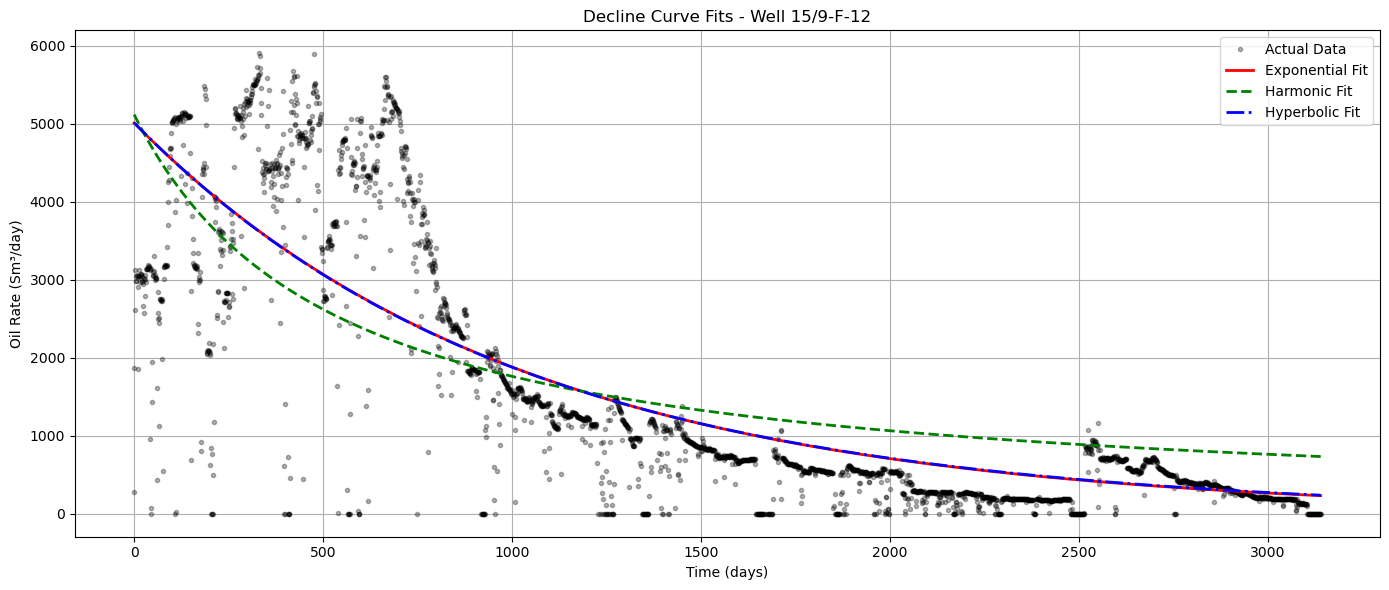

In [177]:
# 4.4 Plot Actual vs. Decline Curve Model Fits

# Plot actual vs. all fitted decline curves
plt.figure(figsize=(14, 6))
plt.plot(t, q, 'k.', alpha=0.3, label='Actual Data')

# Plot model fits
plt.plot(t, q_fit_exp,  'r-', linewidth=2, label='Exponential Fit')
plt.plot(t, q_fit_harm, 'g--', linewidth=2, label='Harmonic Fit')
plt.plot(t, q_fit_hyp,  'b-.', linewidth=2, label='Hyperbolic Fit')

plt.title("Decline Curve Fits - Well 15/9-F-12")
plt.xlabel("Time (days)")
plt.ylabel("Oil Rate (Sm³/day)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# 4.5 Evaluate Model Performance

To determine which decline model best fits the historical data, we evaluate each model using two standard metrics:

- RMSE (Root Mean Squared Error): Measures the average deviation between actual and predicted values.
- R² (Coefficient of Determination): Indicates how well the model explains the variance in the data (closer to 1 is better).

These metrics help us assess and compare the quality of the fits.


In [179]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Compute RMSE
rmse_exp = np.sqrt(mean_squared_error(q, q_fit_exp))
rmse_harm = np.sqrt(mean_squared_error(q, q_fit_harm))
rmse_hyp = np.sqrt(mean_squared_error(q, q_fit_hyp))

# Compute R²
r2_exp = r2_score(q, q_fit_exp)
r2_harm = r2_score(q, q_fit_harm)
r2_hyp = r2_score(q, q_fit_hyp)

# Print Results
print("Model Performance Metrics:")
print(f"Exponential: RMSE = {rmse_exp:.2f}, R² = {r2_exp:.4f}")
print(f"Harmonic:    RMSE = {rmse_harm:.2f}, R² = {r2_harm:.4f}")
print(f"Hyperbolic:  RMSE = {rmse_hyp:.2f}, R² = {r2_hyp:.4f}")


Model Performance Metrics:
Exponential: RMSE = 943.61, R² = 0.6779
Harmonic:    RMSE = 1105.57, R² = 0.5578
Hyperbolic:  RMSE = 944.97, R² = 0.6769


In [ ]:
Based on the metrics above:

- The model with the lowest RMSE and highest R² is considered the best fit
- This model will be used for further analysis (e.g., forecasting and OOIP estimation)
- Hyperbolic Decline has the lowest RMSE and highest R², making it the best fitting model for this well


In [ ]:
# 4.6 Estimate Original Oil in Place (OOIP)

Using the fitted hyperbolic model parameters, we can estimate the original oil in place (OOIP) using a simplified material balance approach. 
This analytical estimate is based on the assumption of a constant bottom-hole pressure and solution-gas drive.

The hyperbolic production equation is:
  q(t) = frac{q_i}{(1 + bDt)^{1/b}}

An analytical estimate for OOIP is given by:
  text{OOIP} = frac{q_i}{D \cdot b} \cdot B_o

Where:
- ( q_i ) = Initial production rate (from hyperbolic fit)
- ( D ) = Decline rate
- ( b ) = Hyperbolic exponent
- ( B_o ) = Oil formation volume factor (assumed = 1.2 reservoir bbl/STB if unknown)

Note: At the time of this project, VOLVE’s PVT dataset was currently unavailable due to maintenance. 
Estimations are based on standard assumptions. This section will be updated with actual PVT-derived values once access is restored.


In [181]:
# Assumed formation volume factor (B_o), in res. m3/stock tank m3

B_o = 1.2  # adjust based on real fluid PVT if available

# Hyperbolic model parameters
qi = qi_hyp  # from hyperbolic fit
D = D_hyp
b = b_hyp

# Calculate OOIP (in reservoir Sm3)
OOIP = (qi / (D * b)) * B_o

print(f"Estimated Original Oil in Place (OOIP): {OOIP:,.0f} Sm³")


Estimated Original Oil in Place (OOIP): 609,865,650 Sm³


In [ ]:
# 4.7 Forecast Future Production (Using Best-Fit Model)
Since the Hyperbolic model gave the best performance, we’ll use it to forecast future oil rates.

We will:
- Extend the time array into the future (e.g., +5 or +10 years)
- Use the best-fit hyperbolic parameters qi, D, b
- Plot historical vs. forecasted rates


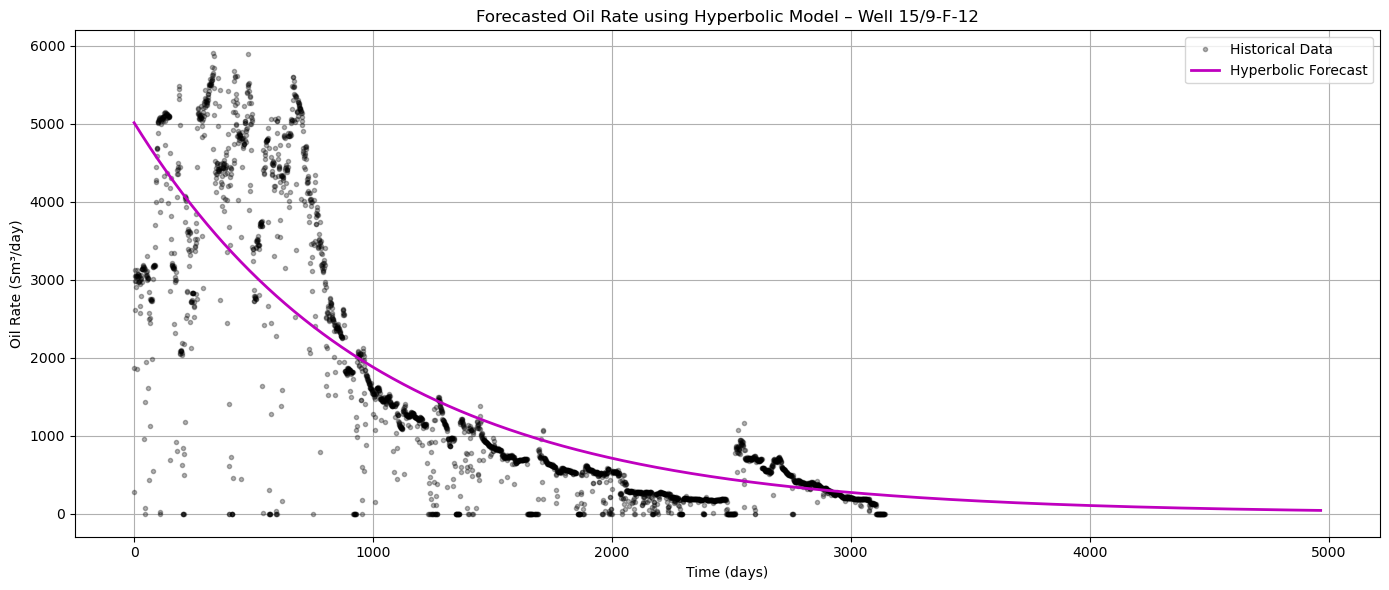

In [183]:
# Extend time by 5 more years (~1825 days)
future_days = np.arange(t.max() + 1, t.max() + 1826)
all_days = np.concatenate([t, future_days])

# Predict future rates using hyperbolic fit
forecast_rate = hyperbolic_model(all_days, qi_hyp, D_hyp, b_hyp)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(t, q, 'k.', alpha=0.3, label='Historical Data')
plt.plot(all_days, forecast_rate, 'm-', linewidth=2, label='Hyperbolic Forecast')

plt.title("Forecasted Oil Rate using Hyperbolic Model – Well 15/9-F-12")
plt.xlabel("Time (days)")
plt.ylabel("Oil Rate (Sm³/day)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# 4.8 Forecast with Economic Limit (Cutoff Rate)
We will assume a typical economic cutoff rate of 100 Sm³/day.

We’ll compute:
- Time at which forecasted rate drops below the cutoff
- Estimated Ultimate Recovery (EUR) up to that point
- Plot cutoff vs shaded cumulative production
    

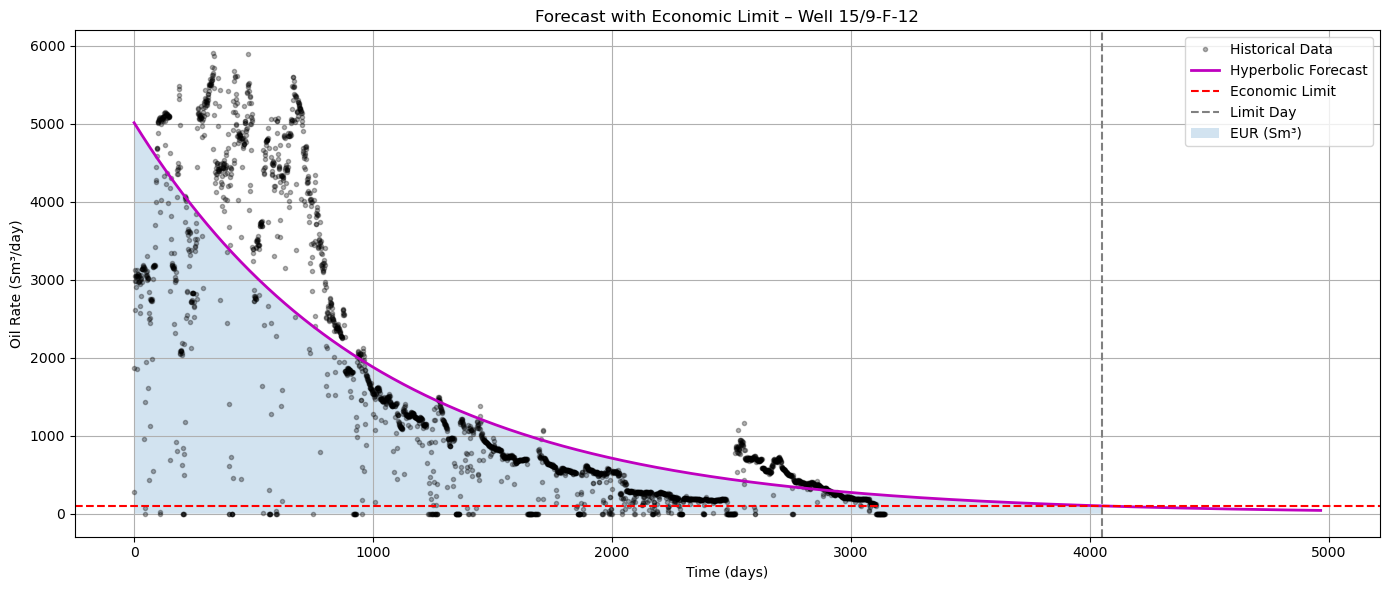

Economic Limit Reached at: 4048 days
Estimated Ultimate Recovery (EUR): 5,026,990 Sm³


In [185]:
# Set economic limit (cutoff rate)
cutoff_rate = 100  # in Sm³/day

# Forecast using hyperbolic model
forecast_rate = hyperbolic_model(all_days, qi_hyp, D_hyp, b_hyp)

# Find index where rate falls below cutoff
cutoff_index = np.argmax(forecast_rate < cutoff_rate)
economic_limit_day = all_days[cutoff_index]

# Compute cumulative production up to economic limit
EUR = np.trapz(forecast_rate[:cutoff_index], all_days[:cutoff_index])

# Plot forecast with economic limit
plt.figure(figsize=(14, 6))
plt.plot(t, q, 'k.', alpha=0.3, label='Historical Data')
plt.plot(all_days, forecast_rate, 'm-', linewidth=2, label='Hyperbolic Forecast')
plt.axhline(y=cutoff_rate, color='red', linestyle='--', label='Economic Limit')
plt.axvline(x=economic_limit_day, color='grey', linestyle='--', label='Limit Day')

plt.fill_between(all_days[:cutoff_index], forecast_rate[:cutoff_index], alpha=0.2, label='EUR (Sm³)')

plt.title("Forecast with Economic Limit – Well 15/9-F-12")
plt.xlabel("Time (days)")
plt.ylabel("Oil Rate (Sm³/day)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print key metrics
print(f"Economic Limit Reached at: {economic_limit_day} days")
print(f"Estimated Ultimate Recovery (EUR): {EUR:,.0f} Sm³")


In [ ]:
# 4.8 Interpretation: Forecast with Economic Limit (Cutoff Rate)

The economic cutoff rate defines the minimum production rate (typically in Sm³/day) at which a well becomes uneconomic to operate
Below this threshold, operating costs begin to exceed revenue, prompting well abandonment or intervention

In this case, a cutoff rate of 100 Sm³/day was assumed — a typical threshold in mature fields on the Norwegian Continental Shelf

# Key Results:

- Forecast Model Used: Hyperbolic decline
- Cutoff Rate: 100 Sm³/day
- Economic Limit Reached: Day 4048 (~11.1 years from production start)
- Estimated Ultimate Recovery (EUR): 5,026,990 Sm³

# Interpretation:

- The well is expected to produce economically for ~11 years, after which production falls below viable limits
- The shaded region in the forecast plot represents cumulative production up to the economic limit
- This EUR estimate informs planning for:
  - Reservoir depletion and abandonment timelines
  - Net Present Value (NPV) and economic modeling
  - Potential Enhanced Oil Recovery (EOR) opportunities

# Notes:
- EUR only reflects recoverable volumes under current conditions; it does not include any recovery from secondary or tertiary methods
- The gap between OOIP and EUR gives an insight into recovery efficiency, guiding future development or EOR screening
